# Rapport
- Balthazar Neveu
- balthazarneveu@gmail.com
- [Lab 2 on github](https://github.com/balthazarneveu/MVA23_SIGNAL/tree/lab_2)

Commençons par une première passe d'homogénéisation du jeu de donnée. En effet, l'échantillonnage temporal n'est pas régulier... l'horodatage n'est pas le même pour tous les signaux.
Afin de simplifier la visualisation et le travail sur les données, nous allons simplement ré-échantillonner le tout (timestamps réguliers, échantillonnage à 10HZ).
Chaque signal aura 100 échantillons ce qui permet d'avoir un volume raisonnable et même de supperposer les différents signaux pour les comparer.

In [86]:
from utilities import homogenize_dataset, get_hand_crafted_features, ALL_CLASSIFIERS, train_classifier, get_better_features, extract_peaks
from matplotlib import pyplot as plt
import scipy

import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
from utilities import homogenize_dataset
num_samples = 100
df = df_train = homogenize_dataset(dataset="train", num_samples=num_samples)
df_test = homogenize_dataset(dataset="test", num_samples=num_samples)
extract_peaks(df_train, add_to_df=True)
extract_peaks(df_test, add_to_df=True)
df.head()


,largeur,frequence,puissance,theta,phi,menace,timestamps_interval_multiples,impulsion_freq,peaks_loc,peaks_val
0,"[0.00029099999999999997, 0.0002911010187641941...","[2222011346.301772, 2201167919.9721026, 221708...","[-125.58248735699023, -115.0846158693843, -108...","[0.9578859532471261, 0.8703978859546783, 0.607...","[1.678935775441994, 1.7243409379102963, 1.6140...",False,"[16.0, 8.0, 20.0, 26.0, 12.0, 1.0, 26.0, 4.0, ...",677.048070,"[2, 6, 8, 10, 13, 16, 21, 25, 30, 35, 40, 45, ...","[-108.21630369700614, -129.064810778739, -136...."
1,"[0.00013800000000000002, 0.0001369258365512231...","[3011221070.570557, 2996006530.9250755, 300603...","[-127.176799666022, -157.8781625154061, -137.9...","[2.7962717807754327, -2.829550985701179, -2.48...","[1.5296932038533972, 1.5546468454693552, 1.632...",False,"[17.0, 6.0, 7.0, 10.0, 2.0, 35.0, 25.0, 55.0, ...",1092.896175,"[3, 9, 13, 20, 27, 36, 45, 51, 58, 62, 66, 72,...","[-134.28594495282678, -156.43742404333207, -14..."
2,"[0.000201, 0.0002018786859303869, 0.000201, 0....","[991990464.3038368, 982743904.1435359, 9898809...","[-149.880060930416, -151.7229884218102, -153.5...","[-2.0412578355641227, -1.9204468635231988, -1....","[1.6722396416013094, 1.7759924411327765, 1.509...",True,"[15.0, 5.0, 3.0, 1.0, 2.0, 41.0, 1.0, 20.0, 13...",634.517766,"[7, 11, 15, 19, 22, 26, 30, 33, 37, 40, 44, 47...","[-160.1894729112234, -163.2840780476702, -165...."
3,"[6.800000000000001e-05, 6.928607233324905e-05,...","[1666424017.2021985, 1668061021.2198102, 16641...","[-135.68775777002037, -134.56670065032353, -13...","[-2.621701006244045, -2.2862588398101207, -2.1...","[1.4039557266900524, 1.6190396944122287, 1.690...",False,"[16.0, 3.0, 2.0, 2.0, 8.0, 15.0, 6.0, 23.0, 10...",1466.275660,"[1, 8, 11, 20, 22, 32, 42, 52, 62, 71, 83, 85,...","[-134.56670065032353, -140.1700103525957, -142..."
4,"[0.000324, 0.0003248032831089071, 0.0003248041...","[2207809393.1871147, 2200771938.7002068, 22022...","[-172.60362010919195, -151.87364054688302, -15...","[2.274032092616462, 2.127649080211378, 2.36297...","[1.6134753329852611, 1.6012352706627135, 1.745...",False,"[17.0, 1.0, 4.0, 5.0, 25.0, 27.0, 1.0, 21.0, 2...",604.960678,"[1, 5, 7, 12, 25, 32, 38, 48, 57, 65, 76, 85, 95]","[-151.87364054688302, -151.5424503909395, -155..."


In [101]:
x_train, y_train, labels_features = get_better_features(df_train)
x_test, y_test, _ = get_better_features(df_test)

[-3.29815441e-15  4.00458418e-16 -1.06737731e-14 -2.12873801e-16
  1.60461270e-15  4.62013962e-17  1.01712547e-16  4.21023250e-16
  1.86195101e-17  2.71400202e-15 -2.26355577e-15] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 2.36884632e-15 -7.94108208e-16  2.25481051e-15  1.80637038e-17
 -1.09327093e-15  1.09493835e-16  5.11341769e-17  3.69909916e-15
  2.28575329e-17 -3.86146406e-15  9.61301682e-15] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


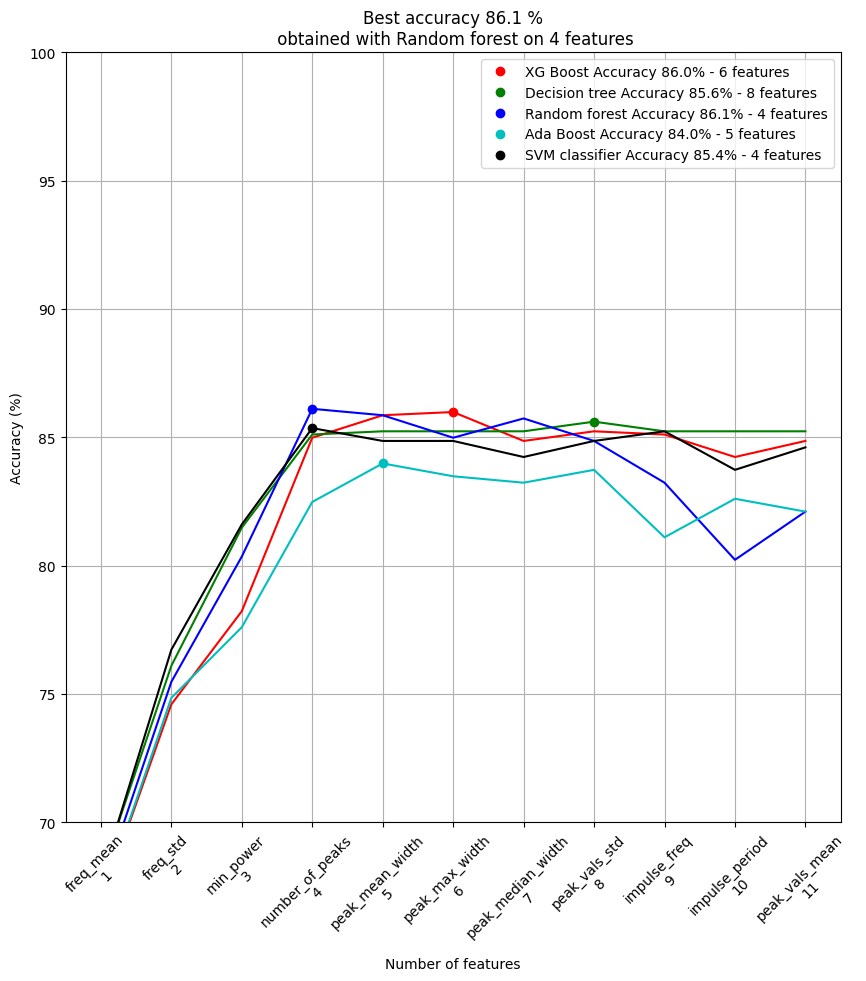

In [114]:
whiten=True
x_train, y_train, labels_features = get_better_features(df_train, whiten=whiten)
x_test, y_test, _ = get_better_features(df_test,  whiten=whiten)

from utilities import ALL_CLASSIFIERS, DECISION_TREE, RANDOM_FOREST, SVM, ADABOOST, XG_BOOST
COLOR_LIST = "rgbckyp"
best_accuracies_overall = []
best_feature_dimensions = []
# classifiers_list = ALL_CLASSIFIERS #[DECISION_TREE, RANDOM_FOREST, SVM, ADABOOST]
# classifiers_list = [SVM]
classifiers_list = [XG_BOOST,  DECISION_TREE, RANDOM_FOREST, ADABOOST, SVM]
scanned_feature_dimension = list(range(1, len(labels_features)+1))
plt.figure(figsize=(10, 10))
for classifier_index, classifier_type in enumerate(classifiers_list):
    best_accuracies = []
    feature_dimensions = []
    color = COLOR_LIST[classifier_index%len(COLOR_LIST)]
    for feature_dimension in scanned_feature_dimension:
        accuracies, best_depth, _ = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=feature_dimension, debug=False,  show=False, classifier=classifier_type)
        # print(f"#features={feature_dimension} Tree depth={best_depth} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
        best_accuracies.append(accuracies)
        feature_dimensions.append(feature_dimension)
    # plt.plot(feature_dimensions, 100.*np.array(best_accuracies)[:, 0], color+"--", alpha=0.1) #label=f"{classifier_type} accuracy training")
    plt.plot(feature_dimensions, 100.*np.array(best_accuracies)[:, 1], color+"-") #label=f"{classifier_type} accuracy validation")
    best_index = np.argmax(np.array(best_accuracies)[:, 1])
    best_accuracy = best_accuracies[best_index][1]
    best_feature_dimension = feature_dimensions[best_index]
    plt.plot(feature_dimensions[best_index], 100.*best_accuracy, color+"o", label=f"{classifier_type} Accuracy {100*best_accuracy:.1f}% - {best_feature_dimension} features")
    plt.legend()
    best_accuracies_overall.append(best_accuracy)
    best_feature_dimensions.append(best_feature_dimension)
best_classifier_index = np.argmax(np.array(best_accuracies_overall))
plt.title(f"Best accuracy {100*best_accuracies_overall[best_classifier_index]:.1f} %\n"+ 
          f" obtained with {classifiers_list[best_classifier_index]}" +
          f" on {best_feature_dimensions[best_classifier_index]} features")
new_labels = labels_features[:len(scanned_feature_dimension)]
new_labels = [f"{label}\n{feature}" for label, feature in zip(new_labels, scanned_feature_dimension)]
plt.xticks(scanned_feature_dimension, new_labels, rotation=45)
plt.xlabel("Number of features")
plt.ylabel(r"Accuracy (%)")
plt.ylim(70, 100)
plt.grid()
plt.show()



## Phase exploratoire
On commence par chercher des critères simples (statistiques basiques des signaux)  pour classifier les données.

### Min puissance
- Si on fait défiler les signaux de puissance en figeant l'échelle verticale, nous remarquons clairement un "paquet" au dessus des autres.
- Un descripteur très simple pour discriminer la menace correspond au mimimum de la puissance. On sait déjà qu'il n'est pas suffisant (au vu du gros "paquet" vert et rouge)

![](figures/superposition_signaux_puissance.png)


### Moyenne et puissance des fréquences

- L'étude de l'évolution temporelle des fréquences ne révèle pas de fluctuations perceptibles (signaux stationnaires).

![](figures/superposition_signaux_frequence.png)

- On peut simplement évaluer les moments et ainsi tracer la distribution moyenne des fréquences ainsi que l'écart type



En poussant un peu l'étude manuelle des caractéristiques, on commence à arriver à distinguer quelques groupes:
- écart type(1/fréquence)/moyenne(1/fréquence)
- min(puissance)

![](figures/x=freq_avg_y=freq_std_div_freq_avg.png)


Un arbre de décision devrait permettre de classifier les données (partitionner l'espace en plusieurs rectangles).


## Classification basique
Une approche rationnelle consiste à aggréger les caractéristiques et entraîner un classifieur simple (arbre de décisions) en jouant sur sa profondeur.
Plus on ajoute de caractéristiques, plus on espère que la précision du modèle augmente


![decision_tree](figures/decision_tree.png)

- Avec une unique caractéristique (bien choisie) et un unique seuil, nous atteignons 70% de précision.
- En augmentant la profondeur de l'arbre de décision jusqu'à 4, nous atteignons une précision de 75%
- Avec 2 caractéristiques, nous remarquons qu'il est nécessaire d'avoir une profondeur de 4 sur l'arbre de décision afin d'atteindre la précision optimale.
- Nous remarquons qu'au delà d'une profondeur de 6, l'arbre de décision est à la limite de "sur-apprentissage" (la précision sur la base d'entraînement augmente alors que la précision de validation stagne ou commence à diminuer.)

### Basic classifier

In [ ]:
# Define the training and testing sets by extracting the features from the dataframes.
x_train, y_train = get_hand_crafted_features(df_train)
x_test, y_test = get_hand_crafted_features(df_test)

In [ ]:
compare_plots = True
for feature_dimension in range(1, 5):
    accuracies, best_depth, _ = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=feature_dimension, debug=True,  show=not compare_plots)
    print(f"#features={feature_dimension} Tree depth={best_depth} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
if compare_plots:
    plt.grid()
    plt.show()

# Analyzing the time series

Let's first retieve some remaining "difficult" signals to classify.

In [ ]:
features_to_keep = 2
accuracies, best_depth, classifier = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=features_to_keep, debug=False,  show=False, forced_depth=4)
y_train_pred = classifier.predict(x_train[:, :features_to_keep])
missclassified_indexes = np.where(y_train_pred!=y_train)[0]

In [ ]:
all_indexes = df.index.values
# Get indexes that are not in missclassified_indexes
not_missclassified_indexes = np.setdiff1d(all_indexes, missclassified_indexes)

# Generate
num_indexes_to_choose = 100  # specify the number of indexes you want
random_indexes = np.random.choice(not_missclassified_indexes, num_indexes_to_choose, replace=False)
df_random = df.take(random_indexes).copy().reset_index()

In [ ]:
df_hard = df.take(missclassified_indexes).copy()
df_hard.reset_index(inplace=True)

In [ ]:
df_hard.menace.sum()/len(df_hard)

In [ ]:
plt.plot(np.array([df_hard.puissance[idx] for idx in range(len(df_hard)) if df_hard.menace[idx]]).T, "r", alpha=0.05, label="menace")
plt.plot(np.array([df_hard.puissance[idx] for idx in range(len(df_hard)) if not df_hard.menace[idx]]).T, "g", alpha=0.05, label="safe")
plt.plot(np.array([df_random.puissance[idx] for idx in range(len(df_random)) if not df_random.menace[idx]]).T, "g", alpha=0.1, label="safe")
plt.grid()
plt.show()

In [ ]:
peaks, props =  scipy.signal.find_peaks(df_hard.puissance[0])
plt.plot(df_hard.puissance[0], "k-", label="power")
plt.plot(peaks, df_hard.puissance[0][peaks], "xr", label="extracted peaks")
plt.grid()
plt.title("Extraction of peaks from the power signal")
plt.legend()
plt.show()
# np.average(peaks[1:] - peaks[:-1])

In [ ]:
peaks, peak_vals = extract_peaks(df, add_to_df=True)
plt.hist([len(el) for idx, el in enumerate(df.peaks_loc) if df.menace[idx]], color="r", bins=40, label="menace", density=True)
plt.hist([len(el) for idx, el in enumerate(df.peaks_loc) if not df.menace[idx]], color="g", bins=40, alpha=0.5, label="safe", density=True)
plt.title("Histogram of number of peaks per signal")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.hist([el for idx, el in enumerate(df.impulsion_freq) if df.menace[idx]], color="r", bins=100, label="menace", density=True)
plt.hist([el for idx, el in enumerate(df.impulsion_freq) if not df.menace[idx]], color="g", bins=100, alpha=0.5, label="safe", density=True)
plt.title("Histogram of impulsion periods")
plt.grid()
plt.xlim(0, 7500)
plt.legend()
plt.show()

In [ ]:
# Define the training and testing sets by extracting the features from the dataframes.

x_train, y_train = get_better_features(df_train)
x_test, y_test = get_better_features(df_test)

In [ ]:
COLOR_LIST = "rgbckyp"
best_accuracies_overall = []
best_feature_dimensions = []
classifiers_list = ALL_CLASSIFIERS #[DECISION_TREE, RANDOM_FOREST, SVM, ADABOOST]
plt.figure(figsize=(10, 10))
for classifier_index, classifier_type in enumerate(classifiers_list):
    best_accuracies = []
    feature_dimensions = []
    color = COLOR_LIST[classifier_index%len(COLOR_LIST)]
    for feature_dimension in range(1, 8):
        accuracies, best_depth, _ = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=feature_dimension, debug=False,  show=False, classifier=classifier_type)
        # print(f"#features={feature_dimension} Tree depth={best_depth} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
        best_accuracies.append(accuracies)
        feature_dimensions.append(feature_dimension)
    plt.plot(feature_dimensions, 100.*np.array(best_accuracies)[:, 0], color+"--", alpha=0.1) #label=f"{classifier_type} accuracy train")
    plt.plot(feature_dimensions, 100.*np.array(best_accuracies)[:, 1], color+"-") #label=f"{classifier_type} accuracy validation")
    best_index = np.argmax(np.array(best_accuracies)[:, 1])
    best_accuracy = best_accuracies[best_index][1]
    best_feature_dimension = feature_dimensions[best_index]
    plt.plot(feature_dimensions[best_index], 100.*best_accuracy, color+"o", label=f"{classifier_type} Accuracy {100*best_accuracy:.1f}% - {best_feature_dimension} features")
    plt.legend()
    best_accuracies_overall.append(best_accuracy)
    best_feature_dimensions.append(best_feature_dimension)
best_classifier_index = np.argmax(np.array(best_accuracies_overall))
plt.title(f"Best accuracy {100*best_accuracies_overall[best_classifier_index]:.1f} % obtained with {classifiers_list[best_classifier_index]} on {best_feature_dimensions[best_classifier_index]} features")
plt.xlabel("Number of features")
plt.ylabel(r"Accuracy (%)")
plt.grid()
plt.show()


In [ ]:
colors = ["r" if el else "g" for el in df["menace"]]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train[:, 2], x_train[:, 0], x_train[:, 1], color=colors)
plt.show()
